In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150
from scipy.io import savemat
from tenpy.tools.params import get_parameter
from matplotlib import colors
import matplotlib.pyplot as plt
import sys
from tenpy.models.mixed_xk import MixedXKLattice
from tenpy.models.lattice import Lattice
from tenpy.networks.terms import TermList

import numpy as np
import itertools as it
import warnings

/Users/gleb/TeNPy/tenpy/tools/optimization.py:307: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
tenpy.tools.misc.setup_logging(to_stdout="INFO")
import pickle
from tenpy.tools.misc import to_array, inverse_permutation, to_iterable

In [3]:
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.algorithms import dmrg
from tenpy.networks.site import SpinSite, SpinHalfSite, SpinHalfFermionSite, FermionSite
from tenpy.models.lattice import Triangular, Square
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel, CouplingMPOModel
# from tenpy.models.mixed_xk import MixedXKModel

# MixedXK lattice class with N, k_y conservation law

In [4]:
# copied class form mixed_mk tenpy model
# changed 
class MixedXKLattice(Lattice):
    r"""Lattice for fermions with mixed real and momentum space on a cylinder.
    This class represents a square lattice cylinder with a unit cell of `N_orb` fermionic orbitals,
    where we indentify the y-direction (around the cylinder) as momentum space.
    The full lattice unit cell consists of a 'ring', which is repeated in cylinder direction:
    indices :math:`(x, u= k * N_{orb} + l)` in the lattice correspond to the ring :math:`x`,
    momentum :math:`k_y = 2\pi k/L_y` around the cylinder, and orbital `l`.
    Indices are related by ``u = k * N_orb + l``, ``k = u // N_orb``, and ``l = u % N_orb``,
    see :meth:`get_u`, :meth:`get_k`, :meth:`get_l`.
    Note that the DMRG snake might wind in a different order, as specified by :attr:`ring_order`.
    .. warning ::
        Using the Jordan-Wigner string (``JW``) is crucial to get correct results!
        See :doc:`/intro/JordanWigner` for details.
    See :mod:`tenpy.models.mixed_xk` for the mappings between x,k and x,y.
    Parameters
    ----------
    N_rings : int
        Number of rings in the MPS unit cell.
    Ly : int
        The circumference of the cylinder: the number of possible `k` values.
    N_orb: int
        Number of orbitals. A single 'ring' of the cylinder contains ``N_orb*Ly`` sites.
    sites : list of :class:`~tenpy.networks.site.Site`
        The sites making up the unit cell, in the order specified by ring_order.
    ring_order : 1D array, len Ly*N_orb
        Gives the order of the sites within a ring for the DMRG snake;
        sites are labeled by the index ``u = k*N_orb + l`` of the :attr:`unit_cell`.
        Defaults to ``np.arange(Ly*N_orb)``.
    orbital_names : None | list of str
        Names for the orbitals, e.g. ``['spin', 'valley', 'ky']``
    orbital_values : array, shape (len(sites), len(orbital_names))
        Values for the orbitals, one row for each site in `sites`.
    **kwargs :
        Further keyword arguments given to :class:`~tenpy.models.lattice.Lattice`.
    Attributes
    ----------
    Ly : int
        The circumference of the cylinder: the number of possible `k` values.
    N_orb: int
        Number of orbitals. A single 'ring' of the cylinder contains ``N_orb*Ly`` sites.
    ring_order : 1D array, len ``Ly*N_orb``
        Gives the order of the sites within a ring for the DMRG snake;
        sites are labeled by the index ``u = k*N_orb + l`` of the :attr:`unit_cell`.
        Defaults to ``np.arange(Ly*N_orb)``.
    delta_q : ndarray, shape (L_y, Ly, Ly)
        ``delta_q[q][k1, k2]`` is the Kronecker :math:`\delta_{k1+q \mod Ly, k2}`.
    orbital_names : None | list of str
        Names for the orbitals, e.g. ``['spin', 'valley', 'ky']``
    orbital_values : None | array, shape (len(sites), len(orbital_names))
        Values for the orbitals, one row for each site in the *unit cell*.
    """
    def __init__(self,
                 N_rings,
                 Ly,
                 N_orb,
                 sites,
                 ring_order=None,
                 orbital_names=None,
                 orbital_values=None,
                 **kwargs):
        self.N_orb = N_orb
        self.Ly = Ly
        self._init_extra_attributes(Ly)
        N_sites_per_ring = Ly * N_orb
        if ring_order is None:
            self.ring_order = np.arange(N_sites_per_ring, dtype=np.intp)
        else:
            self.ring_order = np.asarray(ring_order, dtype=np.intp)
            inv_ring_order = inverse_permutation(self.ring_order)
            sites = [sites[i] for i in inv_ring_order]
            if orbital_values is not None:
                orbital_values = orbital_values[inv_ring_order, :]
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        basis = [np.array([1., 0.])]
        kwargs.setdefault("basis", basis)
        positions = [np.array([l / (2. * N_orb), k]) for k in range(Ly) for l in range(N_orb)]
        kwargs.setdefault("positions", positions)
        if 'order' in kwargs:
            raise NotImplementedError("Use `ring_order` to change the order!")
        # initialize Lattice
        super().__init__([N_rings], sites, **kwargs)
        # redefine define self.order
        order = np.zeros((self.N_sites, 2), np.intp)
        for x in range(N_rings):
            order[x * N_sites_per_ring:(x + 1) * N_sites_per_ring, 0] = x
            order[x * N_sites_per_ring:(x + 1) * N_sites_per_ring, 1] = self.ring_order
        self.order = order  # uses property setter
        self.orbital_names = orbital_names
        self.orbital_values = orbital_values

    @classmethod
    def from_charges_of_orbitals(cls,
                                 N_rings,
                                 Ly,
                                 N_orb,
                                 chinfo,
                                 charges,
                                 conserve_k=True,
                                 ring_order=None,
                                 **kwargs):
        """Initialize from chages, defining default Sites.
        Parameters
        ----------
        N_rings : int
            Number of rings in the MPS unit cell.
        Ly : int
            The circumference of the cylinder: the number of possible `k` values.
        N_orb: int
            Number of orbitals. A single 'ring' of the cylinder contains ``N_orb*Ly`` sites.
        chinfo : :class:`~tenpy.linalg.charges.ChargeInfo`
            The nature of the charges. If `conserve_k` is True, the charge ``"ky"`` for the
            momentum around the cylinder is added.
        charges : array_like of shape (N_orb, chinfo.qnumber)
            For each of the oribals the value of each charges (except ``"ky"``),
            when the orbital is occupied.
        ring_order : 1D array, len Ly*N_orb
            Gives the order of the sites within a ring for the DMRG snake;
            sites are labeled by the index ``u = k*N_orb + l`` of the :attr:`unit_cell`.
            Defaults to ``np.arange(Ly*N_orb)``.
        conserve_k : bool
            Whether to add "ky" as separate charge to `chinfo`.
        **kwargs :
            Further keyword arguments given to :class:`~tenpy.models.lattice.Lattice`.
        Returns
        -------
        lat : cls
            Instance of this class, with the sites initialized according to the charges of the
            orbitals defined above.
        """
        # initialize sites of the unit cell with given charges
        assert len(charges) == N_orb
        if conserve_k:
            chinfo_k = npc.ChargeInfo([Ly], ["ky"])
            chinfo = npc.ChargeInfo.add([chinfo, chinfo_k])
        qflat = np.zeros((2, chinfo.qnumber), dtype=int)
        unit_cell = [None] * (Ly * N_orb)
        for l in range(N_orb):
            if conserve_k:
                qflat[1, :-1] = charges[l]
            else:
                qflat[1, :] = charges[l]
            for k in range(Ly):
                if conserve_k:
                    qflat[1, -1] = k
                leg_unsorted = npc.LegCharge.from_qflat(chinfo, qflat, qconj=+1)
                perm_qind, leg = leg_unsorted.sort()
                perm_flat = leg_unsorted.perm_flat_from_perm_qind(perm_qind)
                site = FermionSite(conserve='N')
#                 site = FermionSite(conserve = None)
                site.change_charge(leg, perm_flat)
                u = k * N_orb + l  # self.get_u(k, l), but we don't have `self` yet.
                unit_cell[u] = site
        return cls(N_rings, Ly, N_orb, unit_cell, **kwargs)

    def save_hdf5(self, hdf5_saver, h5gr, subpath):
        """Export `self` into a HDF5 file.
        This method saves all the data it needs to reconstruct `self` with :meth:`from_hdf5`.
        In addition to :meth:`~tenpy.models.lattice.Lattice.save_hdf5`, it saves
        :attr:`ring_order`, :attr:`orbital_names` and :attr:`orbital_values` as HDF5 dataset, and
        :attr:`Ly` and :attr:`N_orb` as HDF5 attributes.
        Parameters
        ----------
        hdf5_saver : :class:`~tenpy.tools.hdf5_io.Hdf5Saver`
            Instance of the saving engine.
        h5gr : :class`Group`
            HDF5 group which is supposed to represent `self`.
        subpath : str
            The `name` of `h5gr` with a ``'/'`` in the end.
        """
        super().save_hdf5(hdf5_saver, h5gr, subpath)
        h5gr.attrs["Ly"] = self.Ly
        h5gr.attrs["N_orb"] = self.N_orb
        hdf5_saver.save(self.ring_order, subpath + "ring_order")
        hdf5_saver.save(self.orbital_names, subpath + "orbital_names")
        hdf5_saver.save(self.orbital_values, subpath + "orbital_values")

    @classmethod
    def from_hdf5(cls, hdf5_loader, h5gr, subpath):
        """Load instance from a HDF5 file.
        This method reconstructs a class instance from the data saved with :meth:`save_hdf5`.
        Parameters
        ----------
        hdf5_loader : :class:`~tenpy.tools.hdf5_io.Hdf5Loader`
            Instance of the loading engine.
        h5gr : :class:`Group`
            HDF5 group which is represent the object to be constructed.
        subpath : str
            The `name` of `h5gr` with a ``'/'`` in the end.
        Returns
        -------
        obj : cls
            Newly generated class instance containing the required data.
        """
        obj = super().from_hdf5(hdf5_loader, h5gr, subpath)
        Ly = hdf5_loader.get_attr(h5gr, "Ly")
        obj.N_orb = hdf5_loader.get_attr(h5gr, "N_orb")
        obj.Ly = Ly
        obj.ring_order = hdf5_loader.load(subpath + "ring_order")
        obj.orbital_names = hdf5_loader.load(subpath + "orbital_names")
        obj.orbital_values = hdf5_loader.load(subpath + "orbital_values")
        obj._init_extra_attributes(Ly)
        return obj

    def get_u(self, k, l):
        """Return unit cell index `u` as a function of momenutm index `k` and orbital `l`."""
        # note: MixedXKModel explicitly uses that this is "c-style" ordering of (k, l)
        return k * self.N_orb + l  # don't change this!

    def get_k(self, u):
        """Return momentum index `k` for given unit cell index `u`."""
        return u // self.N_orb

    def get_l(self, u):
        """Return orbital index `l` for given unit cell index `u`."""
        return u % self.N_orb

    def get_exp_ik(self, ky):
        r"""Return :math:`\exp(\frac{2 pi i }{L_y} ky)`.
        If you need the factor for given `k` and `y`, just give ``k*y`` as argument."""
        return self._exp_2pi_Ly[np.mod(ky, self.Ly)]

    def mps2lat_values_k(self, A, axes=0):
        """Like :meth:`Lattice.mps2lat_values`, but indtroduce `k` as separate lattice index."""
        axes = to_iterable(axes)
        A_res = self.mps2lat_values(A, axes)
        changed_axes = sorted([(ax + A.ndim if ax < 0 else ax) for ax in axes])
        A_res_u_axes = []
        for ax in changed_axes:
            A_res_u_axes.append(ax + (len(self.shape) - 1) * len(A_res_u_axes) + len(self.shape) -
                                1)
        A_res_reshape = list(A_res.shape)
        for ax in A_res_u_axes[::-1]:
            A_res_reshape[ax:ax + 1] = [self.Ly, self.N_orb]
        return A_res.reshape(A_res_reshape)

    def mps2lat_values_masked_k(self, A, axes=-1, mps_inds=None, include_u=None):
        """Like :meth:`Lattice.mps2lat_values_masked`, but introduce `k` as separate lattice
        index."""
        A_res = self.mps2lat_values_masked(A, axes, mps_inds, include_u)
        changed_axes = sorted([(ax + A.ndim if ax < 0 else ax) for ax in axes])
        A_res_u_axes = []
        for ax in changed_axes:
            A_res_u_axes.append(ax + (len(self.shape) - 1) * len(A_res_u_axes) + len(self.shape) -
                                1)
        A_res_reshape = list(A_res.shape)
        for ax in A_res_u_axes[::-1]:
            A_res_reshape[ax:ax + 1] = [self.Ly, self.N_orb]
        return A_res.reshape(A_res_reshape)

    def _init_extra_attributes(self, Ly):
        """Set a few usefull extra attributes defined by Ly only."""
        self._exp_2pi_Ly = np.exp(2.j * np.pi / Ly * np.arange(Ly))
        self.delta_q = np.zeros((Ly, Ly, Ly))
        for q, delta_q in enumerate(self.delta_q):
            for k in range(Ly):
                delta_q[(k + q) % Ly, k] = 1


class MixedXKModel(CouplingMPOModel):
    """Base class for a Hamiltonian represented in mixed x-k-space on a cylinder.
    All parameters are collected in a single dictionary `model_params`, which
    is turned into a :class:`~tenpy.tools.params.Config` object.
    Parameters
    ----------
    xy_lattice : ``"Square"``
        Chooses Real-space lattice geometry.
        TODO: Currently, only "Square" is implemented.
    Attributes
    ----------
    real_space_lattice : TODO ???
        Real-space lattice geometry.
    """
    def init_lattice(self, model_params, N_orb, chinfo, charges):
        """Initialize a MixedXKLattice for the given model parameters.
        Parameters
        ----------
        model_params : dict
            The model parameters given to ``__init__``.
        N_orb : int
            The number of fermionic orbitals for each k-value.
        chinfo : :class:`~tenpy.linalg.charges.ChargeInfo`
            The charges to be conserved, excluding the momentum in y direction "ky".
        charges : array_like of shape (N_orb, chinfo.qnumber)
            For each of the oribals the value of each charges (except ``"ky"``),
            when the orbital is occupied.
        """
        xy_lattice = model_params.get('xy_lattice', "Square")
        if xy_lattice != "Square":
            raise NotImplementedError("Can't choose other than Square for now")
        self.real_space_lattice = xy_lattice
        N_rings = model_params.get('Lx', 1)
        Ly = model_params.get('Ly', 2)
        ring_order = model_params.get('ring_order', None)
        conserve_k = model_params.get('conserve_k', True)
        bc_MPS = model_params.get('bc_MPS', 'infinite')
        bc = 'periodic' if bc_MPS == 'infinite' else 'open'
        lat = MixedXKLattice.from_charges_of_orbitals(N_rings,
                                                      Ly,
                                                      N_orb,
                                                      chinfo,
                                                      charges,
                                                      conserve_k,
                                                      ring_order=ring_order,
                                                      bc=bc,
                                                      bc_MPS=bc_MPS)
        return lat

    def add_intra_ring_hopping(self, couplings):
        r"""Add hopping terms within each ring.
        Parameters
        ----------
        couplings : ndarray, shape (Ly, N_orb, Ly, N_orb)
            ``couplings[k1, l1, k2, l2]`` is the prefactor for a hopping term of the form
            :math:`\sum_i c^\dagger_{x,k1,l1} c_{x,k2,l2}`.
            Should fulfill ``couplings[k1, l1, k2, l2] == conj(couplings[k2, l2, k1, l1])``
            to make the Hamiltonian hermitian.
        """
        N_orb = self.lat.N_orb
        Ly = self.lat.Ly
        N_r = Ly * N_orb
        couplings = to_array(couplings, (Ly, N_orb, Ly, N_orb))
        couplings = np.reshape(couplings, (N_r, N_r), order='C')
        for idx in zip(*couplings.nonzero()):
            strength = couplings[idx]
            u1, u2 = idx
            if u1 == u2:
                self.add_onsite(strength, u1, 'N')  # Cd C
            else:
                self.add_coupling(strength, u1, 'Cd', u2, 'C', 0, op_string='JW')

    def add_inter_ring_hopping(self, couplings, dx=+1):
        r"""Add hopping terms between different rings.
        Parameters
        ----------
        couplings : ndarray, shape (Ly, N_orb, Ly, N_orb)
            ``couplings[k1, j1, k2, j2]`` is the prefactor for a hopping term of the form
            :math:`\sum_x c^\dagger_{x,k1,l1} c_{x+dx,k2,l2} + h.c.`.
        dx : int
            Distance between the rings; use dx > 1 for long-range hoppings.
        """
        assert dx != 0
        N_orb = self.lat.N_orb
        Ly = self.lat.Ly
        N_r = Ly * N_orb
        couplings = to_array(couplings, (Ly, N_orb, Ly, N_orb))
        couplings = np.reshape(couplings, (N_r, N_r), order='C')
        for idx in zip(*couplings.nonzero()):
            strength = couplings[idx]
            u1, u2 = idx
            self.add_coupling(strength, u1, 'Cd', u2, 'C', dx, op_string='JW', plus_hc=True)

    def add_intra_ring_interaction(self, couplings, operators=('Cd', 'C', 'Cd', 'C')):
        r"""Add intra-ring interaction terms.
        Parameters
        ----------
        couplings : ndarray, shape (Ly, N_orb, Ly, N_orb, Ly, N_orb, Ly, N_orb)
            ``couplings[k1,j1, k2,j2, k3,j3, k4,j4]`` is the prefactor for a hopping term
            of the form
            :math:`\sum_i A_{i,k1,j1} B_{i,k2,j2} C_{i,k3,j3} D_{i,k4,j4}`.
        operators: tuple of 4 str
            The 4 operators `A,B,C,D` to be used, 'Cd' for (fermionic) creation and 'C' for
            annihilation operators of given ring, momentum and orbital.
        """
        N_orb = self.lat.N_orb
        Ly = self.lat.Ly
        N_r = Ly * N_orb
        couplings = to_array(couplings, (Ly, N_orb, Ly, N_orb, Ly, N_orb, Ly, N_orb))
        couplings = np.reshape(couplings, (N_r, N_r, N_r, N_r), order='C')
        A, B, C, D = operators
        for idx in zip(*couplings.nonzero()):
            strength = couplings[idx]
            u1, u2, u3, u4 = idx
            if u1 == u2 == u3 == u4:
                self.add_onsite(strength, u1, ' '.join([A, B, C, D]))  # Cd C Cd C
            else:
                self.add_multi_coupling(strength, [(A, 0, u1), (B, 0, u2), (C, 0, u3), (D, 0, u4)])

    def add_inter_ring_interaction(self, couplings, dx, operators=('Cd', 'C', 'Cd', 'C')):
        r"""Add inter-ring interaction terms.
        Parameters
        ----------
        couplings : ndarray, shape (Ly, N_orb, Ly, N_orb, Ly, N_orb, Ly, N_orb)
            ``couplings[k1, j1, k2, j2, k3, j3, k4, j4]`` is the prefactor for a term
            .. math ::
                \sum_i A_{i,k1,j1} B_{i,k2,j2} C_{i+dx,k3,j3} D_{i+dx,k4,j4}
            For the default `operators`, it should fulfill
            ``coulings[k1,j1, k2,j2, k3,j3, k4,j4] = conj(coulings[k2,j2, k1,j1, k4,j4, k3,j3])``
            to make the Hamiltonian hermitian.
        dx : int
            Distance between the rings; use dx > 1 for long-range interactions.
        operators: tuple of 4 str
            The 4 operators `A,B,C,D` to be used, 'Cd' for (fermionic) creation and 'C' for
            annihilation operators of given ring, momentum and orbital.
        """
        assert dx != 0
        N_orb = self.lat.N_orb
        Ly = self.lat.Ly
        N_r = Ly * N_orb
        couplings = to_array(couplings, (Ly, N_orb, Ly, N_orb, Ly, N_orb, Ly, N_orb))
        couplings = np.reshape(couplings, (N_r, N_r, N_r, N_r), order='C')
        A, B, C, D = operators
        for idx in zip(*couplings.nonzero()):
            strength = couplings[idx]
            u1, u2, u3, u4 = idx
            self.add_multi_coupling(strength, [(A, 0, u1), (B, 0, u2), (C, dx, u3), (D, dx, u4)])

    #==========================#
    # Correlation calculations #
    #==========================#

    # convenience functions for expectation values/correlations
    def real_to_mixed_onsite(self, A, A_coord):
        r"""Terms to be measured in x-k space for real space onsite observables.
        Provide the necessary terms which can be measured in an MPS with
        :meth:`~tenpy.networks.mps.MPS.expectation_value_sum_terms` to evaluate a
        onsite observable :math:`A_{x,y}` in real space
        where :math:`A_{x,y} = \sum_{l1,l2} A_{l1,l2} c^\dagger_{x,y,l1} c_{x,y,l2}`
        with the provided matrix elements ``A[l1,l2]`` and coordinates ``x, y = A_coord``.
        Parameters
        ----------
        A : array_like, shape (N_orb, N_orb)
            Matrix elements (with respect to the orbitals) of the operator to be measured.
        A_coord : (int, int)
            ``x, y`` coordinates of the operator in real-space.
        Returns
        -------
        terms : :class:`~tenpy.networks.terms.TermList`
            Terms representing the operator `A` in x-k-space.
        """
        xk_lat = self.lat
        N_orb = xk_lat.N_orb
        Ly = xk_lat.Ly
        conserve_k = 'ky' in xk_lat.site(0).leg.chinfo.names
        x, y = A_coord
        A = np.asarray(A)
        if A.shape != (N_orb, N_orb):
            raise ValueError("wrong shape of A")
        terms = []
        strengths = []
        for l1, l2 in zip(*A.nonzero()):
            coeff = A[l1, l2]
            for k1 in range(Ly):
                u1 = xk_lat.get_u(k1, l1)
                i1 = xk_lat.lat2mps_idx((x, u1))
                for k2 in range(Ly):
                    u2 = xk_lat.get_u(k2, l2)
                    i2 = xk_lat.lat2mps_idx((x, u2))
                    fourier_coeff = xk_lat.get_exp_ik((k1 - k2) * y) / Ly
                    if conserve_k and (k1 - k2) % Ly != 0:
                        #only keep terms with momentum conservation
                        continue
                    strengths.append(coeff * fourier_coeff)
                    terms.append([('Cd', i1), ('C', i2)])
        return TermList(terms, strengths)

    def real_to_mixed_two_site(self, A, A_coord, B, B_coord):
        r"""Terms to be measured in x-k-space for real space correlation functions.
        Provide the necessary terms which can be measured in an MPS with
        :meth:`~tenpy.networks.mps.MPS.expectation_value_sum_terms` to evaluate a
        correlation function :math:`A_{x1,y1} B_{x1,y2}`,
        where :math:`A_{x1,y1} = \sum_{l1,l2} A_{l1,l2} c^\dagger_{x1,y1,l1} c_{x1,y1,l2}`
        with the provided matrix elements ``A[l1,l2]`` and coordinates ``x1, y1 = A_coord``,
        and similar `B`.
        Parameters
        ----------
        A : array_like, shape (N_orb, N_orb)
            Matrix elements with respect to the orbitals for the first operator.
        A_coord : (int, int)
            ``x, y`` coordinates of the operator in real-space.
        B : array_like, shape (N_orb, N_orb)
            Matrix elements with respect to the orbitals for the second operator.
        B_coord : (int, int)
            ``x, y`` coordinates of the operator in real-space.
        Returns
        -------
        terms : :class:`~tenpy.networks.terms.TermList`
            Terms representing the correlation function in x-k-space.
        """
        return self.real_to_mixed_n_site([A, B], [A_coord, B_coord])

    def real_to_mixed_n_site(self, orbital_coeffs, rs_coords):
        r"""Terms to be measured in x-k-space for real space correlation functions.
        Provide the necessary terms which can be measured in an MPS with
        :meth:`~tenpy.networks.mps.MPS.expectation_value_sum_terms` to evaluate a n-site
        correlation function :math:`A_{x1,y1} B_{x2,y2} C_{x3,y3} ...`,
        where :math:`A_{x,y} = \sum_{l1,l2} A_{l1,l2} c^\dagger_{x,y,l1} c_{x,y,l2}`
        with the provided matrix elements ``orbital_coeffs[0][l1,l2]`` and coordinates
        ``x1, y1 = rs_coords[0]``, and similar the other `n` operators `B`, `C`, ....
        Parameters
        ----------
        orbital_coeffs : list of array_like, shape (N_orb, N_orb)
            Matrix elements with respect to the orbitals for each of the operators.
        rs_coord : list of tuple
            For each operator iin `orbital_coeffs` the according real-space coordinates ``x, y``.
        Returns
        -------
        terms : :class:`~tenpy.networks.terms.TermList`
            Terms representing the correlation function in x-k-space.
        """
        num_ops = len(orbital_coeffs)
        orbital_coeffs = [np.asarray(op) for op in orbital_coeffs]
        assert num_ops == len(rs_coords)
        num_c_cd = num_ops * 2
        xk_lat = self.lat
        N_orb = xk_lat.N_orb
        Ly = xk_lat.Ly
        conserve_k = 'ky' in xk_lat.site(0).leg.chinfo.names
        terms = []
        strengths = []
        xx_ind = np.repeat([x for x, y in rs_coords], 2)
        y_ind = [y for x, y in rs_coords]
        ops = ['Cd', 'C'] * num_ops

        for l_ind in it.product(*[zip(*op_i.nonzero()) for op_i in orbital_coeffs]):
            # l_ind = [(l1, l2) for each operator]  where orb_coeff is non-zero
            coeff = np.prod([op_i[l_i] for op_i, l_i in zip(orbital_coeffs, l_ind)])
            for k_ind in it.product(range(Ly), repeat=num_c_cd):
                # k_ind = [k1, k2, k3, k4, ...]
                if conserve_k and (sum(k_ind[::2]) - sum(k_ind[1::2])) % Ly != 0:
                    #only keep terms with momentum conservation
                    continue
                kdiff_y = sum([(k1 - k2) * y for k1, k2, y in zip(k_ind[::2], k_ind[1::2], y_ind)])
                fourier_coeff = xk_lat.get_exp_ik(kdiff_y) / Ly**num_ops
                strengths.append(coeff * fourier_coeff)
                u_ind = xk_lat.get_u(np.array(k_ind), np.array(l_ind).flatten())
                i_ind = xk_lat.lat2mps_idx(np.hstack([xx_ind[:, np.newaxis],
                                                      u_ind[:, np.newaxis]]))
                # i_ind = MPS index for combination (x,k,l) of each operator
                terms.append(list(zip(ops, i_ind)))  # [('Cd', i1), ('C', i2), ...]
        return TermList(terms, strengths)

    def real_to_mixed_correlations_any(self, ops, coeff_orbitals, rs_coords):
        """Terms to be measured in x-k-space for real space correlation functions.
        Provide the necessary terms which can be measured in an MPS with
        :meth:`~tenpy.networks.mps.MPS.expectation_value_sum_terms` to evaluate a
        real-space correlation function of creation and annihilation operators::
            sum([coeff * prod(ops[i]_{rs_coords[i],orbitals[i]} for i in len(ops))
                    for coeff, orbitals in coeff_orbitals])
            # rs_coords[i] = pair of x, y coordinates
        Parameters
        ----------
        ops : list of ``'C' | 'Cd'``
            Operators to be measured, 'Cd' for creation, 'C' for annihilation operator.
            Each operator acts on a site `x, y, l` specified by an entry ``x, y`` in rs_coords
            and a `l` in the `orbitals` of `coeff_orbitals`.
        coeff_orbitals : list of (coeff, orbitals)
            `orbitals` is a list with one orbital `l` index for each operator in `ops`,
            `coeff` is a prefactor for that orbital combination.
        rs_coords : list of (int, int)
            real-space coordinates ``x,y`` where each of the operators act.
        Returns
        -------
        terms : :class:`~tenpy.networks.terms.TermList`
            Terms representing the correlation function in x-k-space.
        """
        num_ops = len(ops)
        assert num_ops == len(rs_coords)
        assert all([num_ops == len(orbs) for _, orbs in coeff_orbitals])
        #TODO: add support for 'N' and '1-N' by splitting them
        # Currently supported by use of orbital_coeffs
        xk_lat = self.lat
        N_orb = xk_lat.N_orb
        Ly = xk_lat.Ly
        conserve_k = 'ky' in xk_lat.site(0).leg.chinfo.names
        terms = []
        strengths = []
        x_ind = np.array([x for x, y in rs_coords])
        y_ind = np.array([y for x, y in rs_coords])
        k_sign = np.array([(+1 if op == 'Cd' else -1) for op in ops])
        coeff_orbitals = [(c, np.asarray(l_ind)) for c, l_ind in coeff_orbitals]
        for k_ind in it.product(range(Ly), repeat=num_ops):
            # k_ind = [k1, k2, k3, k4, ...]
            k_ind = np.array(k_ind)
            if conserve_k and (np.sum(k_ind * k_sign)) % Ly != 0:
                #only keep terms with momentum conservation
                continue
            k_y = np.sum(k_ind * k_sign * y_ind)
            fourier_coeff = xk_lat.get_exp_ik(k_y) / Ly**(num_ops / 2.)
            for coeff, l_ind in coeff_orbitals:
                strengths.append(coeff * fourier_coeff)
                u_ind = xk_lat.get_u(k_ind, l_ind)
                i_ind = xk_lat.lat2mps_idx(np.hstack([x_ind[:, np.newaxis], u_ind[:, np.newaxis]]))
                # i_ind = MPS index for combination (x,k,l) of each operator
                terms.append(list(zip(ops, i_ind)))  # [('Cd', i1), ('C', i2), ...]
        return TermList(terms, strengths)

# Spinless mixed model 

In [5]:
class MySpinlessMixed(MixedXKModel):

    # initialize lattice
    def init_lattice(self, model_params):
        N_orb = 1
        chinfo = npc.ChargeInfo([1], ["Charge"])
        charges = [[1]]
        return MixedXKModel.init_lattice(self, model_params, N_orb, chinfo, charges)

    def init_terms(self, model_params):
        t = model_params["t"]
        V = model_params["V"]
        xk_lat = self.lat
        Ly = xk_lat.Ly
        N_orb = xk_lat.N_orb
        assert N_orb == 1
        l = 0  # only 1 orbital

        # hopping
        intra_hopping = np.zeros((Ly, N_orb, Ly, N_orb), dtype=complex)
        inter_hopping = np.zeros((Ly, N_orb, Ly, N_orb), dtype=complex)
        cos_k = np.real(xk_lat.get_exp_ik(np.arange(Ly)))

        if model_params["flux"]:
            for k in range(Ly):
                
                '''on-site coupling'''
                self.add_onsite([(-t) * 2 * np.cos(2 * np.pi/Ly *k), (-t) * (-2) * np.cos(2 * np.pi/Ly *k)], k, 'N')

                ''' hopping between rings'''
                strength = [(-t) * (-1j + (-1) * np.exp(-1j * 2 * np.pi/Ly * k)), (-t) * (-1j + (+1) * np.exp(-1j * 2 * np.pi/Ly * k))]
                dx = 1
                self.add_coupling(strength, k, 'Cd', k, 'C', dx, op_string='JW', plus_hc=True)
        else:
            for k in range(Ly):

                '''on-site coupling'''
                self.add_onsite((-t) * 2 * np.cos(2 * np.pi/Ly *k), k, 'N')

                ''' hopping between rings'''
                strength = (-t) * (1 + (+1) * np.exp(-1j * 2 * np.pi/Ly * k))
                dx = 1
                self.add_coupling(strength, k, 'Cd', k, 'C', dx, op_string='JW', plus_hc=True)
                
        ''' density-density interaction '''
        n_q = xk_lat.delta_q
        intra_interaction = np.zeros((Ly, N_orb, Ly, N_orb, Ly, N_orb, Ly, N_orb), dtype=complex)
        inter_interaction = np.zeros((Ly, N_orb, Ly, N_orb, Ly, N_orb, Ly, N_orb), dtype=complex)
        for q in range(Ly):
            intra_interaction[:, 0, :, 0, :, 0, :, 0] += \
                V / Ly * cos_k[q] * (n_q[q][:, :, np.newaxis, np.newaxis] *
                                     n_q[-q][np.newaxis, np.newaxis, :, :])
            inter_interaction[:, 0, :, 0, :, 0, :, 0] += \
                V / Ly * (1 + np.exp(-1j * 2 * np.pi/Ly * q)) * (n_q[q][:, :, np.newaxis, np.newaxis] *
                          n_q[-q][np.newaxis, np.newaxis, :, :])
        self.add_intra_ring_interaction(intra_interaction)
        self.add_inter_ring_interaction(inter_interaction, 1)



# DMRG parameters

In [6]:
# if flux = True, Lx = 2
# if flux = False, Lx = 1

model_params = {"xy_lattice" : "Square",
              "Ly" : 3,
              "Lx" : 3,
              "t" : 1.0,
              "V" : 15.0,
              "fraction" : 2,
              "bc_MPS" : "infinite",
              "conserve_k" : True,
              "bc_y" : 'periodic',
              "bc_x" : 'periodic',
              "flux" : False}

In [7]:
M = MySpinlessMixed(model_params)

INFO    : MySpinlessMixed: reading 'xy_lattice'='Square'
INFO    : MySpinlessMixed: reading 'Lx'=3
INFO    : MySpinlessMixed: reading 'Ly'=3
INFO    : MySpinlessMixed: reading 'conserve_k'=True
INFO    : MySpinlessMixed: reading 'bc_MPS'='infinite'
INFO    : MySpinlessMixed: reading 't'=1.0
INFO    : MySpinlessMixed: reading 'V'=15.0
INFO    : MySpinlessMixed: reading 'flux'=False
['bc_x', 'bc_y', 'fraction']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))



# Configure DMRG + initial state

In [8]:
chi_list = {0:200, 20:400, 40:800}
dmrg_params = {"trunc_params": {"chi_max": 1000, "svd_min": 1.e-10}, "mixer": True, "chi_list" : chi_list,"max_sweeps": 60}

sites = M.lat.mps_sites()
# psi = MPS.from_product_state(sites,["full","empty","empty","full","empty","empty", "full","empty","empty"],"infinite")
psi = MPS.from_product_state(sites,["full","empty","empty"]*3,"infinite")

# Run DMRG

In [9]:
info = dmrg.run(psi, M, dmrg_params)
energy = info['E']
delta_energy = abs(info["sweep_statistics"]['E'][-1] - info["sweep_statistics"]['E'][-2])

INFO    : DMRG: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : DMRG: reading 'chi_list'={0: 200, 20: 400, 40: 800}
INFO    : start environment_sweep
INFO    : trunc_params: reading 'chi_max'=1000
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : DMRG: reading 'max_sweeps'=60
INFO    : DMRG: reading 'mixer'=True
INFO    : activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO    : Running sweep with optimization
INFO    : activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO    : Setting chi_max=200
INFO    : start environment_sweep
INFO    : checkpoint after sweep 10
energy=-0.0713927424126450, max S=1.7646963430381484, age=297, norm_err=9.1e-12
Current memory usage 173472.0MB, wall time: 112.1s
Delta E = nan, Delta S = 1.5431e-01 (per sweep)
max trunc_err = 5.9131e-14, max E_trunc = 2.1458e-12
chi: [200, 200, 200, 200, 200, 200, 200, 200, 200]
INFO    : Running sweep with optimization
INFO    : disable mixer after 15 sweeps, final amp

In [10]:
corr_length = psi.correlation_length()

# Check density-density correlation terms between sites (0,0) and (1,1)

In [11]:
a = M.real_to_mixed_two_site(A = [[1]], A_coord = ((0,0)), B = [[1]], B_coord = ((1,1)))
print(a)

0.11111+0.00000j * Cd_0 C_0 Cd_3 C_3 +
0.11111+0.00000j * Cd_0 C_0 Cd_4 C_4 +
0.11111+0.00000j * Cd_0 C_0 Cd_5 C_5 +
-0.05556+0.09623j * Cd_0 C_1 Cd_3 C_5 +
-0.05556+0.09623j * Cd_0 C_1 Cd_4 C_3 +
-0.05556+0.09623j * Cd_0 C_1 Cd_5 C_4 +
-0.05556-0.09623j * Cd_0 C_2 Cd_3 C_4 +
-0.05556-0.09623j * Cd_0 C_2 Cd_4 C_5 +
-0.05556-0.09623j * Cd_0 C_2 Cd_5 C_3 +
-0.05556-0.09623j * Cd_1 C_0 Cd_3 C_4 +
-0.05556-0.09623j * Cd_1 C_0 Cd_4 C_5 +
-0.05556-0.09623j * Cd_1 C_0 Cd_5 C_3 +
0.11111+0.00000j * Cd_1 C_1 Cd_3 C_3 +
0.11111+0.00000j * Cd_1 C_1 Cd_4 C_4 +
0.11111+0.00000j * Cd_1 C_1 Cd_5 C_5 +
-0.05556+0.09623j * Cd_1 C_2 Cd_3 C_5 +
-0.05556+0.09623j * Cd_1 C_2 Cd_4 C_3 +
-0.05556+0.09623j * Cd_1 C_2 Cd_5 C_4 +
-0.05556+0.09623j * Cd_2 C_0 Cd_3 C_5 +
-0.05556+0.09623j * Cd_2 C_0 Cd_4 C_3 +
-0.05556+0.09623j * Cd_2 C_0 Cd_5 C_4 +
-0.05556-0.09623j * Cd_2 C_1 Cd_3 C_4 +
-0.05556-0.09623j * Cd_2 C_1 Cd_4 C_5 +
-0.05556-0.09623j * Cd_2 C_1 Cd_5 C_3 +
0.11111+0.00000j * Cd_2 C_2 Cd_3 C_3 +
0.11111

# Compute correlation function

In [12]:
dist = np.arange(0, 40)
Ly = 3
charge_corr = np.zeros(len(dist))

In [13]:
# M.real_to_mixed_correlations_any(ops = ["Cd", "C", "Cd", "C"], coeff_orbitals = [[1,1],[1,1],[1,1],[1,1]],  rs_coords =  [[0,0],[0,0],[1,1],[1,1]])
# M.real_to_mixed_two_site(A = [[1]], A_coord = ((0,0)), B = [[1]], B_coord = ((1,1)))

In [14]:
for j,d in enumerate(dist):
#     print(j, d)
    x_d = d // Ly
    y_d = d % Ly
    print(x_d, y_d)
    terms_mixed_space = M.real_to_mixed_two_site(A = [[1]], A_coord = ((0,0)), B = [[1]], B_coord = ((x_d, y_d)))
#     terms_mixed_space = M.real_to_mixed_n_site(orbital_coeffs = [[[1]], [[1]]], rs_coords = [(0,0),(x_d,y_d)])
    charge_corr[j] = psi.expectation_value_terms_sum(terms_mixed_space)[0]

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2
5 0
5 1
5 2
6 0
6 1
6 2
7 0
7 1
7 2
8 0
8 1
8 2
9 0
9 1
9 2
10 0
10 1
10 2
11 0
11 1
11 2
12 0
12 1
12 2
13 0


Text(0.5, 1.0, 'Conserve ky, V = 15.0, corr_length = 1.413630933545931')

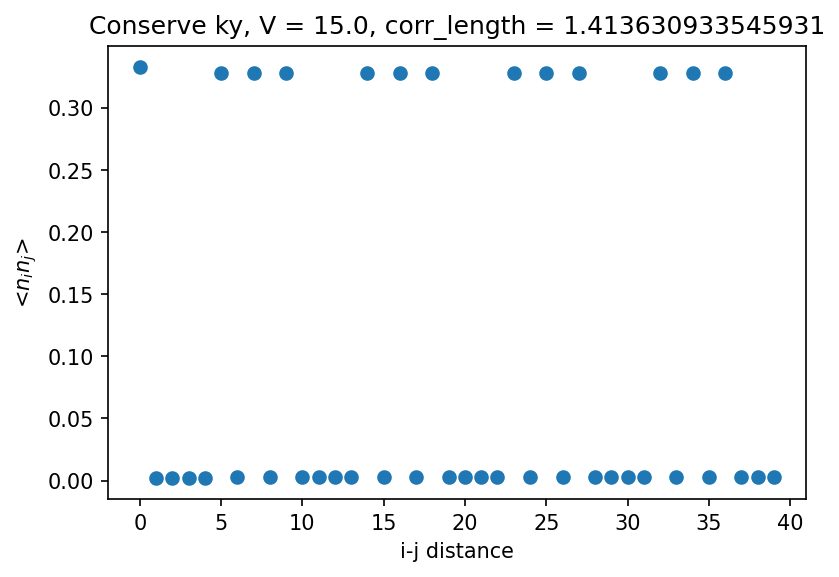

In [15]:
plt.figure()
plt.scatter(dist, charge_corr)
# plt.ylim([0, 0.4])
plt.xlabel('i-j distance')
plt.ylabel('<$n_i n_j$>')   
plt.title("Conserve ky, V = " + str(model_params["V"]) + ", corr_length = " + str(corr_length))
# plt.savefig("flux_mixed_conserved_Ly_3_Lx_2_half_filling_2.pdf")